In [1]:
import os
import pandas as pd
import numpy as np
import math
import gensim
import random
from itertools import chain
import torch
import dgl
import dgl.function as fn
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report,f1_score,accuracy_score,recall_score,precision_score
from gensim.models import KeyedVectors
import re
from itertools import combinations
from PIL import Image
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import pickle
from tokenizers import  BertWordPieceTokenizer
from transformers import BertTokenizer,BertModel

Using backend: pytorch


In [2]:
labels = 3
max_length = 60 #36
pixel = 49
batch_size = 16
embed_size = 300
DEVICE = 'cuda:2'
windows = 2
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [3]:
# def setup_seed(seed):
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.manual_seed(seed) #cpu
#     torch.cuda.manual_seed_all(seed)  #并行gpu
#     dgl.seed(seed)
#     dgl.random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     torch.backends.cudnn.deterministic = True  #cpu/gpu结果一致
#     torch.backends.cudnn.benchmark = False   #训练集变化不大时使训练加速
#     torch.backends.cudnn.enabled = False
# setup_seed(2020)

In [4]:
from itertools import combinations
def get_batch_graph(batch_size,max_len,windows):
    batch_graph = []
    for i in range(batch_size):
        g = dgl.DGLGraph()
        g.add_nodes(max_len)
        # A couple edges one-by-one
        for j in range(windows,max_len+1):
            t = range(j-windows,j)
            edges = np.array(list(combinations(t,2)))
            for edge in edges:
                g.add_edges(edge[0],edge[1])
                g.add_edge(edge[1], edge[0])
#         g.add_edge(max_length -1, 0)

        batch_graph.append(g)
    return batch_graph

def get_fusion_batch(batch_size,max_len,windows):
    batch_graph = []
    for i in range(batch_size):
        g = dgl.DGLGraph()
        g.add_nodes(max_len + pixel)

    
        # text with pixel
        for j in range(max_length,max_length + pixel):
            for i in range(0,max_length):
                g.add_edges(i,j)
                g.add_edge(j, i)
        
        batch_graph.append(g)
        
    return batch_graph
    
batch_graph = get_batch_graph(batch_size,max_length,windows)
batch_fusion_graph = get_fusion_batch(batch_size,max_length,windows)

def get_next_batch(batch_size,batch_graph = batch_graph):
    batch_graph = batch_graph[0:batch_size]
    bg = dgl.batch(batch_graph, edge_attrs=None)
    bg = bg.to(torch.device(DEVICE))
    return bg


/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: DGLGraph.add_edge is deprecated. Please use DGLGraph.add_edges
  return warnings.warn(message, category=category, stacklevel=1)


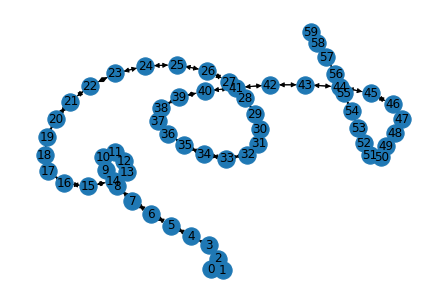

In [5]:

import networkx as nx
import matplotlib.pyplot as plt
g_nx = batch_graph[0]
nx.draw(g_nx.to_networkx(), with_labels=True)
plt.show()


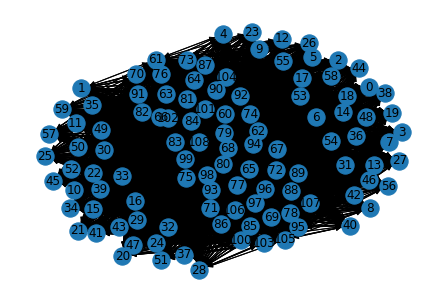

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
g_nx = batch_fusion_graph[0]
nx.draw(g_nx.to_networkx(), with_labels=True)
plt.show()


#### 数据读取

In [7]:
 
def read_text(path):
    with open(path,mode='r',encoding='gbk') as f:
        text = f.read()
        text = text.strip().lower().replace('#',' # ')
#         text = text.strip().lower()

    return str(text)

# Preprocess image
tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])

def read_img(path):
    img = tfms(Image.open(path)).unsqueeze(0)
    return img



texts = []
images = torch.Tensor()
y = []
index_ID_dict = {}
all_data = pd.read_csv('./dataset/MVSA_Single/labelResultAll.csv')
for index,row in all_data.iterrows():
    ID = row['ID']
    index_ID_dict[index] = ID
    if ID%100 == 0:
        print(ID)
    label = row['label']
    y.append(label)
    text_path = os.path.join('./dataset/MVSA_Single/data/', str(ID)+'.txt')
    texts.append(read_text(text_path))
#     image_path = os.path.join('./dataset/MVSA_Single/data/', str(ID)+'.jpg')
#     image = read_img(image_path)
#     if images.shape[0] ==0:
#         images = image
#     else:
#         images = torch.cat([images, image], 0)
    


label_dict = {'negative' : 0, 'neutral' : 1, 'positive' : 2 }
y = [label_dict[l] for l in y]
y = np.array(y)

# torch.save(images,'./dataset/single_images.pkl')
# torch.save(y,'./dataset/single_y.pkl')

images = torch.load('./dataset/single_images.pkl')

                    

100
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1700
1800
1900
2000
2100
2500
2600
2700
2800
2900
3100
3200
3300
3400
3500
3600
3700
3800
4000
4100
4200
4300
4500
4600
4700
4800
5000
5100


In [8]:
images.shape

torch.Size([4511, 3, 224, 224])

#### 数据预处理

In [9]:

pad = np.array([102] * max_length)

# texts = [t.split(' ') for t  in texts]
# texts = [tokenizer.encode(t).tokens[1:-1] for t  in texts]
# texts = [tokenizer.encode(t).tokens[1:-1] for t  in texts]
texts_tmp = []

for t  in texts:
    token = tokenizer(t,return_tensors = 'pt')['input_ids'].numpy()[0]
    if len(token)>= max_length:
        token = token[0:max_length]
    else:
        token = np.concatenate((token,pad[0:max_length-len(token)])) 
    token = np.reshape(token,(1,-1))
    if len(texts_tmp)==0:
        texts_tmp = token
    else:
        texts_tmp = np.vstack((texts_tmp,token))
        
x_texts   = texts_tmp    



#### 构建数据集

In [10]:
shuffle_index = list(range(len(y)))
random.Random(2019).shuffle(shuffle_index) 
train_index = int(len(y) * 0.8)
val_index = int(len(y) * 0.1)
train_texts = x_texts[shuffle_index[0:train_index]]
train_images = images[shuffle_index[0:train_index]]
train_y = y[shuffle_index[0:train_index]]
test_texts = x_texts[shuffle_index[train_index : train_index + val_index]]
test_images = images[shuffle_index[train_index : train_index + val_index]]
test_y = y[shuffle_index[train_index : train_index + val_index]]
val_texts = x_texts[shuffle_index[train_index + val_index : ]]
val_images = images[shuffle_index[train_index + val_index : ]]
val_y = y[shuffle_index[train_index + val_index : ]]

train_set = data.TensorDataset(torch.LongTensor(train_texts),torch.FloatTensor(train_images) ,torch.LongTensor(train_y))
val_set = data.TensorDataset(torch.LongTensor(val_texts),torch.FloatTensor(val_images), torch.LongTensor(val_y))
test_set = data.TensorDataset(torch.LongTensor(test_texts),torch.FloatTensor(test_images), torch.LongTensor(test_y))

train_data_loader = data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True)
val_data_loader = data.DataLoader(val_set, batch_size=batch_size,
                                        shuffle=False)
test_data_loader = data.DataLoader(test_set, batch_size=batch_size,
                                        shuffle=False)


In [11]:
# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    h = nodes.data['h']
    accum = 0.8 * accum + 0.2 * h

    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
       
        h = self.linear(node.data['h'])
        h = self.activation(h)
        
        return {'h1' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature

        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
      
        return g.ndata.pop('h1')


class GAT(nn.Module):
    def __init__(self, input_dim,output_dim, activation):
        super(GAT, self).__init__()
       
        self.norm = nn.BatchNorm1d(input_dim)
        self.merge_linner =  nn.Linear( input_dim , output_dim)
        self.activation = activation
        self.fc = nn.Linear(input_dim, input_dim, bias=False)
        self.attn_fc = nn.Linear(2 * input_dim, 1, bias=False)
    
    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['h'], edges.dst['h']], dim=1)
        a = self.attn_fc(z2)
        return { 'e': F.leaky_relu(a)}
    
    def message_func(self, edges):
        return {'h': edges.src['h'], 'e': edges.data['e']}
    
    def reduce_func(self, nodes):
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)  
        h_ = nodes.data['h']
#         # equation (4)
        h = torch.sum(alpha * nodes.mailbox['h'], dim=1)
        h = 0.9 * h + 0.1 * h_
        h = self.merge_linner(h)
        h = self.activation(h)
        
        return {'h': h}
    
    def forward(self, bg, h):

        # equation (1)
        h = self.fc(h)
        bg.ndata['h'] = h
        # equation (2)
        bg.apply_edges(self.edge_attention)
        # equation (3) & (4)
        bg.update_all(self.message_func, self.reduce_func)
        
        return bg.ndata.pop('h')
    
    
class SelfAttention(nn.Module):
    # refrence:https://blog.csdn.net/uhauha2929/article/details/81951760
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        # (B, L, H) -> (B , L, 1)
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
#         print('weight',weights)
        # (B, L, H) * (B, L, 1) -> (B, H)
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        return outputs


class Classifier(nn.Module):
    def __init__(self, labels,hidden_size = 768,drop_rate = 0.4):
        super(Classifier, self).__init__()
        self.labels = labels

        self.dropout2 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.4)
        self.dropout5 = nn.Dropout(drop_rate)
        self.dropout6 = nn.Dropout(0.6)
        self.hidden_size = hidden_size
        self.bert_model = BertModel.from_pretrained('bert-base-uncased',return_dict = True)
        self.text_normal = nn.LayerNorm((max_length,self.hidden_size))
        self.image_normal = nn.LayerNorm((pixel,self.hidden_size))
        
        self.embed_size = embed_size
        self.GCN = GCN(embed_size, self.hidden_size, F.relu)
        self.GCN2 = GCN(self.hidden_size, self.hidden_size, F.relu)
        self.GAT = GAT(self.hidden_size, self.hidden_size, F.relu)
#         self.multi_head = multi_head(8, self.hidden_size, max_length+pixel)
        self.att = SelfAttention(self.hidden_size)
        self.image_model = EfficientNet.from_pretrained('efficientnet-b0')
        self.image_trans = nn.Linear(1280, self.hidden_size)

        self.classify_h = nn.Linear(self.hidden_size , self.hidden_size)
        self.classify = nn.Linear(self.hidden_size, labels)

    def forward(self,text,image):
        
        bs = text.shape[0]
        bg = get_next_batch(bs)
        bg_fusion = get_next_batch(bs,batch_graph = batch_fusion_graph)
        
#         text = self.embedding(text)
#         text = torch.reshape(text,(-1,self.embed_size))   #[-1,hidden_size]
#         text = self.GCN(bg, text)
        text = self.bert_model(text).last_hidden_state
#         text = torch.reshape(text,(bs,-1,self.hidden_size))   #[bs,max_len,hidden_size]
        text = self.text_normal(text)
        
        img = self.image_model.extract_features(image) #[bs,1280,7,7]  1536
        img = torch.reshape(img,(bs,1280,49))   #[bs,1280,49]
        img = torch.transpose(img,1,2)          #[bs,49,1280]
        img =  torch.reshape(img,(-1,1280))     #[bs*49,1280]
        img = self.image_trans(img)             #[bs*49,hidden_size]
        img = torch.reshape(img,(bs,-1,self.hidden_size))   #[bs,49,hidden_size]
#         img = self.image_normal(img)

        feature = torch.cat([text, img], 1)
        feature_short = torch.reshape(feature,(-1,feature.shape[2]))

        gat_feature = self.GAT(bg_fusion, feature_short)
#         head_feature = self.multi_head(gat_feature,bs)
        feature = feature_short + gat_feature
        feature = torch.reshape(feature,(bs,-1,feature.shape[-1]))
        feature = self.att(feature)
#         feature = torch.cat([feature_short, gat_feature,head_feature], 1)
        

#         feature = torch.reshape(feature,(bs,-1))
        feature = self.dropout5(feature)
        
        feature = self.classify_h(feature)
        feature = F.relu(feature)
        
        return self.classify(feature)
    

In [12]:
def model_test(data_loader,model):
    '''
    使用验证集或测试集测试模型
    '''
    pred_Y = []
    test_Y = []
    loss_l = []
    loss_func = nn.CrossEntropyLoss()
    for step,(b_texts,b_images, test_y_batch) in enumerate(data_loader):

        
        b_texts = b_texts.to(torch.device(DEVICE))
        b_images = b_images.to(torch.device(DEVICE))
        test_y_batch = test_y_batch.to(torch.device(DEVICE))
        
        test_net_out = model(b_texts,b_images)
        loss = loss_func(test_net_out, test_y_batch) 
        loss_l.append(loss.cpu().data.numpy())
        
        test_net_out = test_net_out.cpu().data.numpy()
        pred_y_batch = np.argmax(test_net_out,axis = 1)
        pred_Y = np.concatenate((pred_Y,pred_y_batch), axis=0) 
        test_Y = np.concatenate((test_Y,test_y_batch.cpu().data.numpy()), axis=0)
#     print(classification_report(test_Y,pred_Y,digits = 5))
    f1 = f1_score(test_Y,pred_Y,average='weighted')
    acc = accuracy_score(test_Y,pred_Y)
    loss_mean = np.mean(np.array(loss_l))
    
    return f1,acc,test_Y,pred_Y,loss_mean


In [13]:
# for ii in range(10):
#构造模型 
net = Classifier( labels = labels)

net.to(torch.device(DEVICE))
# print(net)

image_model_params = list(map(id, net.image_model.parameters()))
base_params = filter(lambda p: id(p) not in image_model_params,
                     net.parameters())

#     optimizer = torch.optim.Adam([{'params': base_params, 'lr': 1e-4},
#                                   {'params': net.image_model.parameters(), 'lr': 1e-5}],
#                                  lr=1e-4)

optimizer = torch.optim.Adam(params = net.parameters(),
                             lr = 2e-5)

# print(optimizer)
loss_func = nn.CrossEntropyLoss()


max_acc = 0
# training and testing
for epoch in range(4):
    net.train()
    for step, (b_texts,b_images, b_y) in enumerate(train_data_loader):        # gives batch data
        b_texts = b_texts.to(torch.device(DEVICE))
        b_images = b_images.to(torch.device(DEVICE))
        b_y = b_y.to(torch.device(DEVICE))



        out = net(b_texts,b_images)                               # rnn output
        loss = loss_func(out, b_y) 

        if step %100 ==0:
            print('epoch:%d, step:%d, loss:%.2f'%(epoch,step,loss.cpu().data.numpy()))
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

    net.eval()
    #每训练一轮，使用验证集验证
    f1,acc,test_Y,pred_Y,loss_mean = model_test(val_data_loader,net)

    acc = (f1+acc)/2
    if acc >max_acc:
        max_acc = acc
        torch.save(net, 'best_text.pkl')




net = torch.load('best_text.pkl')
net.eval()
# print(net.embedding.weight)
f1,acc,test_Y,pred_Y,loss_mean = model_test(val_data_loader,net)
# print(net.embedding.weight)
print('--------',f1,acc)



Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.09


/usr/local/lib/python3.6/dist-packages/efficientnet_pytorch/utils.py:75: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:924.)
  return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


epoch:0, step:100, loss:0.51
epoch:0, step:200, loss:0.77
epoch:1, step:0, loss:0.74
epoch:1, step:100, loss:0.93
epoch:1, step:200, loss:0.87
epoch:2, step:0, loss:0.29
epoch:2, step:100, loss:0.53
epoch:2, step:200, loss:0.45
epoch:3, step:0, loss:0.27
epoch:3, step:100, loss:0.11
epoch:3, step:200, loss:0.31
-------- 0.7496580670771925 0.7522123893805309
